In [140]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

### TODO:
    1. Decreasing stepsize in FW (-1 for rho/gamma) + (rho to 1 to disable averaging)
    2. Full dataset training (deterministic FW)
    3. For medium & FW why p-norm is 6001 and not 20? gamma and t was trainable
    4. FW did not converge for -1, -1!
    
    WORKS: {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 100, 'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
    Doesn't work if set R to 30... IN LMO added +eps -> works!

DOESN't WORK: 

In [649]:
# SMALL setting
setting_name = 'small'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1, 'architecture': '20_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, **common}],
    
    'frankwolfe':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': 0.01, 'ro': 0.6,
     'epochs': 200, **common}],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 200, **common}],
}

In [638]:
# medium setting
setting_name = 'medium_auto'
common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
     for lr in [0.1, 0.01, 0.001, 0.0001]],
    
    'frankwolfe_stochastic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
     for ro in [-1.] + list(np.linspace(0, 1, 3))],
    
        'frankwolfe_deterministic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
     'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
}

In [659]:
# BIG setting
setting_name = 'big'
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
param_groups = {
    'sgd':
    [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
     for lr in [1., 0.5, 0.1, 0.05]],
    
    'frankwolfe_stochastic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
     'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
     for ro in [-1.] + [0.1, 0.3, 0.5]],
    
    'frankwolfe_deterministic':
    [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
     'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]],
    
    'adam':
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
}

In [660]:
parameters = [x for group in param_groups.values() for x in group]

In [661]:
def varying_for_optim(d):
    """ What changes for optimizer? """
    d0 = d[0]
    keys = set()
    for v in d:
        for key, val in v.items():
            if d0[key] != val:
                keys.add(key)
    return list(keys)

# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['learning_rate'], 'frankwolfe_stochastic': ['gamma', 'ro'], 'frankwolfe_deterministic': ['gamma'], 'adam': ['learning_rate']}


In [662]:
def print_nice(y):
    if isinstance(y, float):
        return str(round(y, 10))#'%.2g' % y
    return str(y)

In [663]:
def print_one(**kwargs):
    return('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [664]:
# arguments in the correct order

f = open('experiment.py', 'r').readlines()

args_in_order = []
for l in f:
    k = 'parser.add_argument(\'--'
    if l.startswith(k):
        args_in_order.append(l[len(k):].split('\'')[0])

In [665]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(kwargs[x] if x in kwargs else None) for x in args_in_order])+'.output')

In [666]:
out = open('run_' + setting_name + '.sh', 'w')

def write_to_out(s):
    print(s)
    out.write(s + '\n')

it = 0
for params in parameters:
    if it % 4 == 0:
        write_to_out('pids=""')
    write_to_out(print_one(**params))
    #print('echo aba; sleep 3 &')
    #print('pids="$pids $!"')
    if it % 2 == 1:
        write_to_out('sleep 5')
    
    if it % 4 == 3:
        write_to_out('wait $pids')
        write_to_out('sleep 5')
    it += 1
it = len(parameters)
print('Total runs: ', it * common['repetitions'])
print('Total time: ', common['repetitions'] * 5 * it / 4 / 60)

out.close()

pids=""
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 1.0 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.5 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
sleep 5
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.1 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.05 --epochs 1000 --image_side 10 --giveup 100 --accuracy_threshold 0.0 --p 3.0 --repetitions 15 --architecture 50_50_20 &
sleep 5
wait $pids
sleep 5
pids=""
python experiment.py --optimizer frankwolfe --train_batch_size 1000 --R 20.0 --gamma -1.0 --ro -1.0 --epochs 1000 --image_side 10 --giveup 100 --acc

In [570]:
def arr_of_dicts_to_dict_of_arrays(arr):
    """ Array of dicts to dict of arrays """
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

In [616]:
def process_dict(d, do_plot = True, use_random = True):
    """ Process one dictionary from  file, return key metrics or plot them """
    d0 = d
    d = arr_of_dicts_to_dict_of_arrays(d)
    all_keys = d.keys()
    metrics = d
    #print(metrics)
    name = '0'
    
    results = {key: [] for key in all_keys}
    results['hessian_eigens_mean'] = []
    results['hessian_eigens_max'] = []
    del results['hessian_eigens']
    
    for i in range(len(d0)):
        for key, val in metrics.items():
            if key == 'hessian_eigens':
                eigens = val[i]
                results['hessian_eigens_mean'].append(np.mean(eigens))
                results['hessian_eigens_max'].append(np.max(eigens))
            elif isinstance(val[i], list):
                results[key].append(val[i][-1]) # appending LAST loss/accuracy
            else:
                results[key].append(val[i])
    
    if do_plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss', color='b')
        ax1.tick_params('y', colors='b')
        
        ax2.set_ylabel('accuracy', color='r')
        ax2.tick_params('y', colors='r')
        
        for i in range(len(d0)):
            ax1.plot(metrics['train_loss'][i], label = 'train_loss')
            ax1.plot(metrics['test_loss'][i], label = 'test_loss')

            ax2.plot(metrics['train_acc'][i], label = 'train_acc')
            ax2.plot(metrics['test_acc'][i], label = 'test_acc')

        fig.tight_layout()
        #fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
        plt.savefig('figures/' + name + '.eps', bbox_inches = 'tight')
        plt.show()

    return results

In [617]:
def process_file(f, do_plot = False):
    """ Process one file """
    if not os.path.isfile(f):
        print('!!! File  missing ' + f)
        return
    
    content = open(f, 'r').read()
    if content.startswith('Nothing['):
        print('!!! File  is empty')
        return
    try:
        d = eval(content)
        return process_dict(d, do_plot)
    except:
        print('!!! File  cannot be processed')
        return None
    #return d

In [636]:
p = param_groups['frankwolfe_stochastic'][0]
print(p)
print(process_file(get_file(**p), True))

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
!!! File  is empty
None


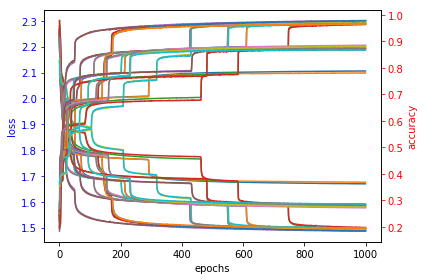

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.6691766, 1.4873391, 1.5803586, 1.4890198, 1.4884175, 1.4886366, 1.493281, 1.4861039, 1.4887214, 1.4916782, 1.4868821, 1.5798125, 1.5787891, 1.5762169, 1.5791763], 'test_loss': [1.6755672, 1.4969739, 1.5878774, 1.4974506, 1.4966966, 1.4950769, 1.5001593, 1.4940711, 1.496712, 1.4988748, 1.4967254, 1.590207, 1.5884037, 1.5856671, 1.5909721], 'train_acc': [0.78835, 0.9773167, 0.88055, 0.9754, 0.9763167, 0.9765667, 0.97211665, 0.9784167, 0.97618335, 0.97295, 0.9779, 0.88125, 0.88296664, 0.8854667, 0.8817833], 'test_acc': [0.7806, 0.9659, 0.8714, 0.9661, 0.9664, 0.9688, 0.9639, 0.969, 0.9657, 0.9646, 0.9658, 0.8689, 0.8722, 0.8751, 0.8678], 'p_norm': [26.472792, 29.764585, 27.942852, 28.817043, 29.283949, 29.810274, 28.854074, 30.071507, 28.900307, 29.166258, 29.440788, 27.97

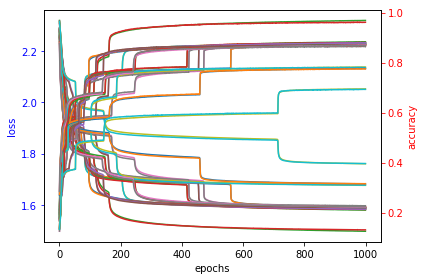

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.5883682, 1.4970937, 1.5843612, 1.5871025, 1.5831155, 1.5844467, 1.5795909, 1.5840516, 1.5900208, 1.6764606, 1.6824242, 1.5880495, 1.5835565, 1.5911492, 1.7606658], 'test_loss': [1.5921772, 1.5026115, 1.5887759, 1.5899947, 1.5878497, 1.5890394, 1.5822619, 1.5882546, 1.5967764, 1.6774246, 1.6827567, 1.5919151, 1.5895878, 1.5925908, 1.7614703], 'train_acc': [0.8755, 0.9689, 0.8789833, 0.8761333, 0.87995, 0.87795, 0.88355, 0.87848336, 0.87278336, 0.78255, 0.77595, 0.87383336, 0.879, 0.8700333, 0.69518334], 'test_acc': [0.8695, 0.9616, 0.8726, 0.8713, 0.8746, 0.8716, 0.8805, 0.8733, 0.8639, 0.7798, 0.7751, 0.868, 0.8711, 0.8678, 0.6931], 'p_norm': [25.184555, 26.634644, 24.823652, 25.575954, 25.376228, 25.511421, 25.884653, 26.061369, 25.758568, 24.275196, 24.256916, 25.8658

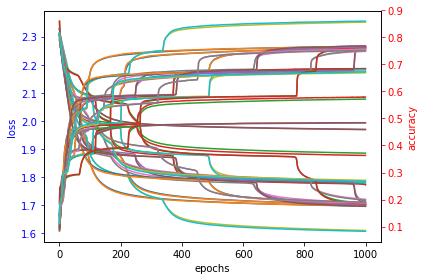

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.7017213, 1.7752013, 1.969975, 1.7092438, 1.7846612, 1.6972677, 1.8855948, 1.7144674, 1.7214217, 1.6105279, 1.7082179, 1.7068467, 1.7006795, 1.708275, 1.7890934], 'test_loss': [1.7026924, 1.7727721, 1.969531, 1.7042527, 1.7800074, 1.6981746, 1.8774629, 1.7085414, 1.7184743, 1.6076849, 1.7074112, 1.70288, 1.6963693, 1.711416, 1.7855008], 'train_acc': [0.76208335, 0.68296665, 0.48365, 0.75645, 0.67576665, 0.7668, 0.5717, 0.75841665, 0.7484, 0.8565, 0.75616664, 0.7607167, 0.76458335, 0.7564667, 0.6689], 'test_acc': [0.7598, 0.6847, 0.4843, 0.7615, 0.6801, 0.7651, 0.5791, 0.7635, 0.7516, 0.86, 0.7567, 0.7643, 0.7687, 0.7512, 0.6722], 'p_norm': [20.84824, 20.45911, 20.00805, 21.216406, 20.372673, 21.47938, 20.412434, 20.712473, 21.496294, 21.793804, 20.752563, 20.705894, 20.8

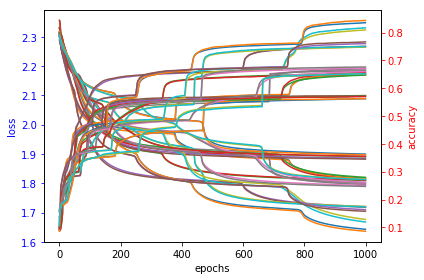

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.05, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.8172232, 1.8096721, 1.7201406, 1.7992439, 1.7206818, 1.8995284, 1.8202184, 1.8853892, 1.8036509, 1.6763369, 1.642966, 1.890851, 1.7099286, 1.7927346, 1.8138648], 'test_loss': [1.8151718, 1.8119438, 1.7180816, 1.8020746, 1.7192805, 1.8971055, 1.8113115, 1.8823164, 1.7955989, 1.667814, 1.6361873, 1.8918254, 1.7043715, 1.7892953, 1.8127387], 'train_acc': [0.64996666, 0.65255, 0.7495667, 0.66618335, 0.74801666, 0.56236666, 0.64746666, 0.57195, 0.6601, 0.80951667, 0.83578336, 0.5715167, 0.7603667, 0.6723833, 0.65195], 'test_acc': [0.6515, 0.649, 0.7506, 0.6632, 0.75, 0.5626, 0.6575, 0.5738, 0.67, 0.8173, 0.8439, 0.5701, 0.7669, 0.6764, 0.6519], 'p_norm': [19.747988, 20.138987, 20.337921, 20.023258, 20.331573, 19.65147, 20.06961, 19.57663, 20.088993, 20.581186, 20.409895, 19

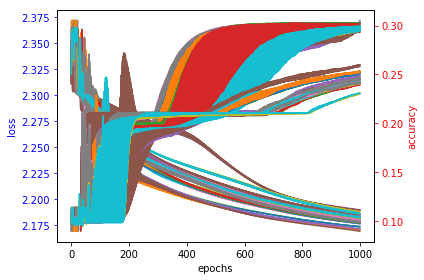

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.1802258, 2.1833239, 2.189822, 2.1765115, 2.1807241, 2.1766183, 2.1735728, 2.1846087, 2.1816792, 2.1817753, 2.1737287, 2.1774547, 2.1715324, 2.1801143, 2.18745], 'test_loss': [2.1784518, 2.181913, 2.189525, 2.1776655, 2.1778688, 2.177766, 2.1707764, 2.1851923, 2.1799543, 2.1829405, 2.171121, 2.1780484, 2.1692617, 2.1785893, 2.1858933], 'train_acc': [0.24411666, 0.24048333, 0.24486667, 0.30106667, 0.24043334, 0.30088332, 0.25021666, 0.30535, 0.24166666, 0.29426667, 0.25268334, 0.3031, 0.2587, 0.2458, 0.22996667], 'test_acc': [0.2452, 0.2393, 0.2409, 0.3012, 0.2416, 0.3011, 0.2517, 0.2978, 0.2421, 0.2945, 0.2534, 0.302, 0.2599, 0.2445, 0.2309], 'p_norm': [5.9345365, 5.9721174, 6.352422, 6.2539134, 5.399506, 6.3038096, 6.1156826, 5.2710156, 5.949765, 

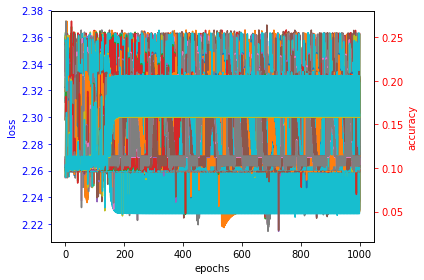

{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': 0.1, 'ro': 1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.2306063, 2.3618367, 2.3290489, 2.3027973, 2.319, 2.312952, 2.3199987, 2.2809575, 2.3025284, 2.2745166, 2.282579, 2.3175082, 2.3009734, 2.3015182, 2.3207734], 'test_loss': [2.2296965, 2.3625574, 2.3295488, 2.300117, 2.316843, 2.3127244, 2.3178587, 2.2815864, 2.3019001, 2.2729964, 2.2811806, 2.3153179, 2.3010175, 2.301538, 2.318646], 'train_acc': [0.20485, 0.09871667, 0.098633334, 0.11236667, 0.16086666, 0.09871667, 0.15953334, 0.17008333, 0.0993, 0.1974, 0.11236667, 0.16288333, 0.10441667, 0.10441667, 0.15846667], 'test_acc': [0.2046, 0.098, 0.0958, 0.1135, 0.162, 0.098, 0.1609, 0.1677, 0.1032, 0.1975, 0.1135, 0.1637, 0.1028, 0.1028, 0.1598], 'p_norm': [5.8793216, 4.339807, 5.042043, 4.8909926, 5.6710896, 4.046155, 5.682141, 4.4945455, 4.2415133, 4.

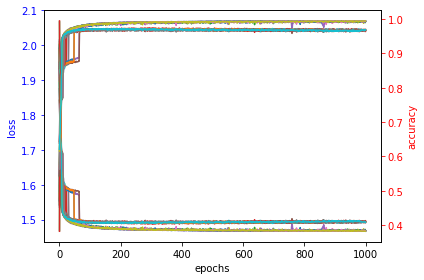

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.4686128, 1.4670599, 1.4675345, 1.4671708, 1.4688762, 1.4675764, 1.4687409, 1.468324, 1.4685899, 1.4677807, 1.4680289, 1.4691768, 1.4689882, 1.4671198, 1.4670904], 'test_loss': [1.4951802, 1.4914281, 1.4938546, 1.4935964, 1.4939972, 1.4931666, 1.4940381, 1.4935083, 1.4941013, 1.4916818, 1.4939783, 1.4969689, 1.4940324, 1.4931142, 1.4930428], 'train_acc': [0.99266666, 0.99411666, 0.99373335, 0.99396664, 0.9923, 0.99363333, 0.9925167, 0.9928833, 0.99265, 0.99345, 0.99326664, 0.9921, 0.99226665, 0.99408334, 0.99405], 'test_acc': [0.9661, 0.9696, 0.967, 0.9674, 0.9667, 0.9679, 0.9669, 0.9674, 0.9665, 0.9689, 0.967, 0.9638, 0.9673, 0.968, 0.968], 'p_norm': [100.131355, 101.948326, 102.19036, 101.81737, 108.82584, 102.92098, 10

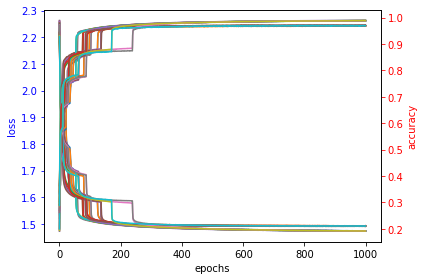

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.4727589, 1.4733589, 1.4733182, 1.4738685, 1.472995, 1.473894, 1.4736375, 1.4726393, 1.4739105, 1.4733396, 1.4740416, 1.473737, 1.4739105, 1.4735497, 1.4735618], 'test_loss': [1.491608, 1.492756, 1.491648, 1.4921224, 1.4917164, 1.4927851, 1.4935235, 1.490823, 1.4911497, 1.4920598, 1.4929594, 1.4918604, 1.4929156, 1.4923222, 1.4923451], 'train_acc': [0.9889, 0.98836666, 0.98838335, 0.98795, 0.98871666, 0.9879, 0.98835, 0.98903334, 0.9879, 0.9884, 0.98775, 0.98808336, 0.9877, 0.98833334, 0.9881333], 'test_acc': [0.9698, 0.9683, 0.9703, 0.9688, 0.9697, 0.9687, 0.9685, 0.9709, 0.9703, 0.9692, 0.9684, 0.9694, 0.9683, 0.9692, 0.969], 'p_norm': [47.363472, 46.1058, 46.352943, 45.868683, 46.057583, 45.24392, 45.909023, 45.978233

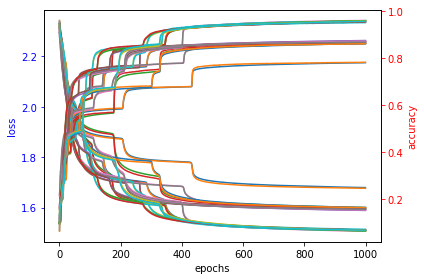

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.50882, 1.5089265, 1.5949187, 1.5920297, 1.5108211, 1.6795198, 1.6005678, 1.5901326, 1.5063443, 1.5076171, 1.6005495, 1.5081227, 1.5890055, 1.5909408, 1.5098951], 'test_loss': [1.5111271, 1.5111406, 1.5981609, 1.595242, 1.5140535, 1.676768, 1.5990343, 1.5937961, 1.5089974, 1.508615, 1.6000508, 1.5114601, 1.5936223, 1.5935844, 1.5104735], 'train_acc': [0.9579, 0.9579333, 0.86855, 0.87161666, 0.95665, 0.7807, 0.8626, 0.8735667, 0.9601667, 0.95888335, 0.86151665, 0.95923334, 0.8749667, 0.87186664, 0.95715], 'test_acc': [0.9562, 0.953, 0.8639, 0.8672, 0.9513, 0.7825, 0.8618, 0.8688, 0.9576, 0.9569, 0.8615, 0.9535, 0.8689, 0.868, 0.9557], 'p_norm': [24.832325, 24.878878, 24.365301, 24.157007, 25.011042, 23.657503, 24.388498,

In [637]:
# parameter id -> processed file
params_to_processed = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), True)
    print(param)
    print(fs)
    print("-----")
    if fs is not None:
        done += 1
    params_to_processed.append(fs)
print('Done: %d/%d' % (done, len(parameters)))

In [550]:
def selection_metric(summary):
    """ Summary of one element in params_to_processed[], a number
    Using mean test accuracy over runs
    """
    return np.mean(summary['test_acc']) if summary is not None else -1

In [551]:
def param_to_result(param):
    """ Parameter setting to results summary """
    idx = parameters.index(param)
    return params_to_processed[idx]

In [552]:
def select_best(optim):
    """ Select best parameters for an optimizer """
    
    metrics = [selection_metric(param_to_result(p)) for p in param_groups[optim]]
    best_idx = np.argmax(metrics)
    return parameters.index(param_groups[optim][best_idx])

In [555]:
for optim in param_groups.keys():
    idx = select_best(optim) # best hyperparameter
    print(optim, params_to_processed[idx])

sgd {'train_loss': [2.041463, 2.0827281, 2.1289213], 'test_loss': [2.0418203, 2.087829, 2.1185126], 'train_acc': [0.45496666, 0.38318333, 0.32713333], 'test_acc': [0.4557, 0.3771, 0.3402], 'p_norm': [11.834844, 11.961177, 11.902492], 'hessian_eigens_mean': [0.0009697952946015908, 0.0007877139841550352, 0.0005321308049746093], 'hessian_eigens_max': [0.27081317, 0.3014176, 0.22538441]}
frankwolfe {'train_loss': [1.5429562, 1.544887, 1.5619218], 'test_loss': [1.5406369, 1.5416254, 1.5582893], 'train_acc': [0.938, 0.93653333, 0.92865], 'test_acc': [0.9409, 0.9389, 0.9298], 'p_norm': [6001.0015, 6001.0015, 6001.0015], 'hessian_eigens_mean': [0.0014924967689348577, 0.001458445412956637, 0.0014961497647408893], 'hessian_eigens_max': [0.36965632, 0.3362363, 0.35704774]}
frankwolfe_deterministic None
adam {'train_loss': [1.5082935, 1.5868391, 1.5043429], 'test_loss': [1.5117545, 1.5959167, 1.5114578], 'train_acc': [0.9558333, 0.8753667, 0.95995], 'test_acc': [0.9514, 0.8646, 0.9511], 'p_norm': 

25